# 0. Introduction

### FUNCOIN installation
Before going through this tutorial, please install the latest version of the FUNCOIN package. If FUNCOIN is not installed, it can be done by calling ```pip install fcin``` in terminal. This will install the FUNCOIN python package and any missing dependencies. 
This tutorial requires FUNCOIN v1.2.3. Upgrade to the newest version by calling ```pip install --upgrade fcin``` in terminal.
See the [README file](https://github.com/kobbersmed/funcoin/blob/main/README.md) in the GitHub repository for more information.

The code block below installs Funcoin or upgrades to the newest version. 

In [1]:
try:
    from funcoin import Funcoin
except:
    !pip install fcin

!pip install fcin --upgrade


### Tutorial outline
This is a tutorial for using FUNCOIN (Functional Connectivity Integrative Normative Modelling) with the python package funcoin as described in [Kobbersmed et al, BioRxiv, 2025](https://www.biorxiv.org/content/10.1101/2025.01.13.632752v1). The tutorial is structured as follows: After a short introduction to the method, we first simulate time series data well-suited for demonstrating FUNCOIN. We then use FUNCOIN to analyse the data and do statistical inference.

The data simulation process is a way of getting more familiar with the model. If you only want an introduction to using the FUNCOIN package, you can run the blocks of code in section 1 and start reading the turorial from section 2.

### The FUNCOIN method
The method is an adaptation of Covariate-Assisted Principal Regression ([Zhao et al. 2021](https://academic.oup.com/biostatistics/article/22/3/629/5680453)) to a normative modelling framework. The method (and this python package) is not specific for normative modelling and can be used for covariance/functional connectivity (FC) regression in general.

In brief, the method is similar to finding principal components. Unlike in traditional PCA, the method identifies components that are shared among all the subjects. Furthermore, instead of finding the components explaining most variance, we identify components and do regression in one step by finding the components that dependent most on covariates specified in the feature matrix *X*. Like with PCA, these components can be found sequentially, with the component most associated with covariates being identified first.

Mathematically, we find the components, $\gamma \in \mathbb{R}^{p}$, and coefficients, $\beta_{0} \in \mathbb{R}$ and $\beta \in \mathbb{R}^{q-1}$, such that
\begin{align*}
    u_{j,i} = \log(\gamma_j^{\top} \Sigma_i \gamma_j) = \beta_0 + x_i^{\top}\beta_j 
\end{align*}
where $\beta_0\in\mathbb{R}$ is the intercept, $\beta \in \mathbb{R}^{q-1}$ are model coefficients, and $x_i\in\mathbb{R}^{q-1}$ is the vector of q-1 covariates of subject i.

In the FUNCOIN adaptation we assume and verify that the residuals in this model are normally distributed with homogenous variance, which allows a more precise estimation of the beta coefficients.


In [2]:
#Import dependencies
import numpy as np
from matplotlib import pyplot as plt
from funcoin import Funcoin
from funcoin import graphics

# 1. Generating example data

### Setting parameters

In the following, we define parameters relevant for the simulation. We have *p*=5 (5 dimensions of time series data), and *q*=3 (3 features in the X matrix including intercept). Here, X<sub>1</sub> is categorical (0 or 1 simulated with equal probability), and X<sub>2</sub> is continuous (between 0 or 1 uniformly random).

We can think of this simulation, as a simulation of fMRI BOLD time series data of 5 brain regions from 200 subjects. X is the feature matrix (shape [no. of subjects] x [no. of features]), where X<sub>0</sub> is the intercept, X<sub>1</sub> is sex (coded as 0 or 1), and X<sub>2</sub> is age (here standardized to range between 0 and 1).

In [3]:
n_subj = 200 # Number of subjects
T = 600 # Number of time points.

# Defining the gamma matrix (same as in the simulation study in Zhao et al (2021)). 
# The gamma matrix is in general of size p x m with m being the number of projections found/defined.
# The columns are the 5 components shared among the subjects in the simulation
gamma_true = np.array([[0.447, 0.447, 0.447, 0.447, 0.447], 
                      [0.447, -0.862, 0.138, 0.138, 0.138],
                      [0.447, 0.138, -0.862, 0.138, 0.138],
                      [0.447, 0.138, 0.138, -0.862, 0.138],
                      [0.447, 0.138, 0.138, 0.138, -0.862]])

# Defining the beta matrix, i.e. the true model coefficients. 
# The beta matrix is of size q x p (here 3x5). 
# This beta matrix specifies that one component depend on sex (with beta_1 = -1) and another component depends on age (with beta_2 = -0.5)
beta_true = np.array([[5, 4, 1, -1, -2],
                     [0, -1, 0, 0, 0],
                     [0, 0, -0.5, 0, 0]])

# Simulating subject features/covariates.
seed = 1
rng = np.random.default_rng(seed=seed)
X1s = rng.binomial(1,0.5,n_subj)
X2s = rng.random(n_subj)

X_sim = np.array([np.ones(n_subj), X1s, X2s]).T #X_sim is of size n_subj x q (here 100 x 3). X_0 is the intercept. In this casae X_1 is a categorical variable (0 or 1) and X_2 is continuous..

print(X_sim.shape)

(200, 3)


### Simulating data

With the Funcoin class method called simulate_data, we generate time series data from predefined Gamma and Beta matrices as well as the covariate matrix (X_sim).

In [4]:
seed = 1234
funcoin_true = Funcoin(gamma = gamma_true, beta=beta_true)

Y_sim = funcoin_true.simulate_data(X_dat = X_sim, n_T=T, seed=seed)

print(f'Number of subjects: {len(Y_sim)}')
print(f'Shape of each subject\'s data: {Y_sim[0].shape}')


Simulating data using predefined Gamma and Beta matrices.
Number of subjects: 200
Shape of each subject's data: (600, 5)


Y_sim is a list of time series data where each element is data from one subject. The shape of each element is T x p ([no. of time points] by [number of regions]).

The following plots show the simulated data for subject 0:


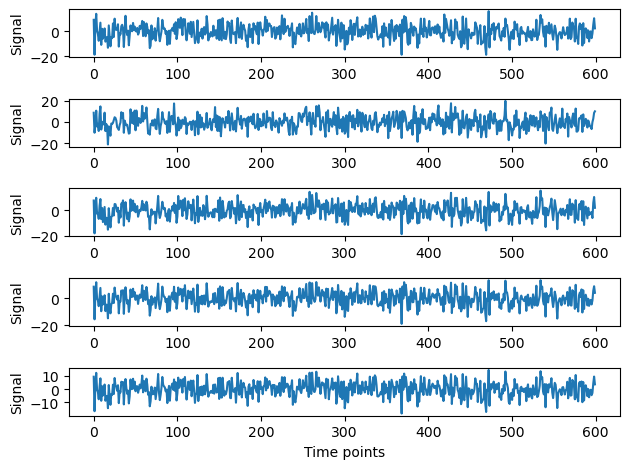

In [5]:
fig, ax = plt.subplots(Y_sim[0].shape[1],1)
for i in range(5):
    ax[i].plot(np.arange(T), Y_sim[0][:,i])
    ax[i].set_ylabel('Signal')

ax[4].set_xlabel('Time points')
plt.tight_layout()
plt.show()


Later in the tutorial, we want to evaluate our model on out-of-sample test data. We therefore also simulate a set of out-of-sample test data from 40 subjects:

In [6]:
#Simulate out-of-sample data from the same model as used above and evaluate scores
seed = 123
n_out = 40
rng = np.random.default_rng(seed=seed)
X1_out = rng.binomial(1,0.5,n_out)
X2_out = rng.random(n_out)
X_out = np.array([np.ones(n_out), X1_out, X2_out]).T #X_out is of size n_out x q (here 50 x 2). X_0 is the intercept. In this casae X_1 is a categorical variable (0 or 1).

Y_out = funcoin_true.simulate_data(X_out, T, seed = seed)

Simulating data using predefined Gamma and Beta matrices.


# 2. FUNCOIN decomposition of the simulated data

### Decomposing from time series data
Having generated time series data for each subject, we now show how to use the FUNCOIN module on existing data.

We can imagine an resting-state fMRI experiment, where we measured the data we just simulated from 200 subjects (Y_sim). We also have data on the subjects' sex and age (in the X matrix). Age is standardized to the interval \[0,1\]. The goal of the FUNCOIN decomposition is to identify components (similar to principal components) of the FC matrix (correlation/covariance). However, different from regular PCA, we identify components that the subjects have in common. Furthermore, we do not necessarily identify the strongest component (like in regular PCA), but the component which depends most on the covariates. That is: In this case, we look for components whose strengths change with sex and age. In the simulation, we defined $\beta$ such that one component depended on sex (coefficient -1) and another depended on age (coefficient -0.5).

Given X (N-by-q feature matrix) and Y (time series data provided as a list of matrices of size T<sub>i</sub>-by-q), we can run the FUNCOIN decomposition. Note that the method allows for the number of time points being different among subjects (hence the subscript in T<sub>i</sub>).

We identify the two first components with FUNCOIN:

In [7]:
max_comps = 2

funcoin_new = Funcoin()
print('Is model fitted already?')
print(funcoin_new.isfitted()) # Check if the model has been fitted already. Distinguishes non-defined or predefined vs fitted Gamma and Beta.
print('\nRunning decomposition')
funcoin_new.decompose(Y_dat=Y_sim, X_dat=X_sim, max_comps=max_comps, seed_initial=123)#or .decompose_ts, which calls the same function
print('\nIs model fitted now?')
print(funcoin_new.isfitted()) # The model is now fitted.

Is model fitted already?
False

Running decomposition

Is model fitted now?
True


### Decomposing from FC matrices
Equivalently, the decomposition can be performed on the FC/covariance/correlation matrices directly.
Compared to the decompose and the equivalent decompose_ts methods, which work on time series data, the decompose_FC takes two additional arguments: 
1. Ti_list, which is a list of Ti values, i.e. the number of time points in the time series data for each subject. If all subjects have the same number of time points, this can also be specified with a single number. 
2. ddof, which is "delta degrees of freedom" following the numpy convention. This specifies the number of degress of freedom used when calculating the FC matrices, i.e. dof = Ti-ddof. Correlation matrices have ddof=0, sample covariance matrices have ddof = 1, and population covariance matrices have ddof=0. Default value is 0. 

This method (decompose_FC) is useful with large time series data, where the FC matrices are calculated beforehand. The method is faster and requires less memory than decompose_ts.

In [8]:
FC_mats = [np.cov(Y_sim[i], rowvar=False, ddof=0) for i in range(len(Y_sim))]
Ti_list = [Y_sim[i].shape[0] for i in range(len(Y_sim))]
ddof = 0

funcoin_FC = Funcoin()
funcoin_FC.decompose_FC(FC_list=FC_mats, X_dat=X_sim, Ti_list=Ti_list, ddof=ddof, seed_initial=123)

Having identified the components, we can calculate the u values for each subject, which are the strength's of the identified components. The transformed data ($u$ values) are stored when running the decomposition. These will be a 2d array of size [no. of subjects] x [no. of components].

As a check, we now verify that we get the same u values, gamma matrix, and beta matrix when fitting with time series data or FC matrices directly. 

In [9]:
u_training = funcoin_new.u_training
print('u values for the first 5 subjects:')
print(u_training[:5,:])

u_training_FC = funcoin_FC.u_training
gamma_ts = funcoin_new.gamma
gamma_FC = funcoin_FC.gamma
beta_ts = funcoin_new.beta
beta_FC = funcoin_FC.beta

print('\nAre the u values, gammas, and betas from the two fits (using time series data or FC matrices) the same?')
print(np.all(np.abs(u_training-u_training_FC)<1e-8))
print(np.all(np.abs(gamma_ts-gamma_FC)<1e-8))
print(np.all(np.abs(beta_ts-beta_FC)<1e-8))

u values for the first 5 subjects:
[[2.95544301 0.80276457]
 [2.9860314  0.66583234]
 [4.12885917 0.49104795]
 [2.97272592 0.72230923]
 [3.9879974  0.61016742]]

Are the u values, gammas, and betas from the two fits (using time series data or FC matrices) the same?
True
True
True


In the above, we specify max_comps = 2, which means that the algorithm stops after identifying 2 projection directions. It may happen that this is not possible, in which case the algorithm will return fewer projections. We can try to identify up to *p* directions. A method for determining the number of projections to consider is described below.

Several other parameters (e.g. tolerance, seed of initial conditions, number of initial conditions, whether to trace solutions from the optimum search algorithm etc.) can be set when calling the decompose method (see method documentation). In this tutorial, the method is run with the default settings (finding best fit from 20 random initial conditions with at most 1000 iterations and tolerance 1e-4).


# 3. Analysis of model fit

The funcoin object has now been fitted with the data provided. The identified gamma projections as well as the coefficients are accesible as instance variables of the fitted Funcoin object:

In [10]:
gamma_fitted = funcoin_new.gamma
beta_fitted = funcoin_new.beta

print('Gamma matrix:')
print(gamma_fitted)
print('\nBeta matrix:')
print(beta_fitted)

Gamma matrix:
[[ 0.4493888   0.33883468]
 [-0.86014424  0.11532073]
 [ 0.13039475 -0.88232017]
 [ 0.12138437  0.17189203]
 [ 0.16267958  0.25269832]]

Beta matrix:
[[ 3.99645407  0.95470662]
 [-0.9909787   0.00953908]
 [-0.00448015 -0.48493182]]


We can compare the above parameters to the true parameters defined in paragraph 1. The fitted gamma projections (columns) and beta coefficients (the columns contain the parameters for each projection) capture the direction and coefficients of the two directions that we simulated as dependent on X<sub>1</sub> and X<sub>2</sub>. This shows that even though we simulated a stronger component, the components whose strength dependet on the covariates were identified.

With funcoin.graphics (imported above), we can easily visualize the identified gammas:

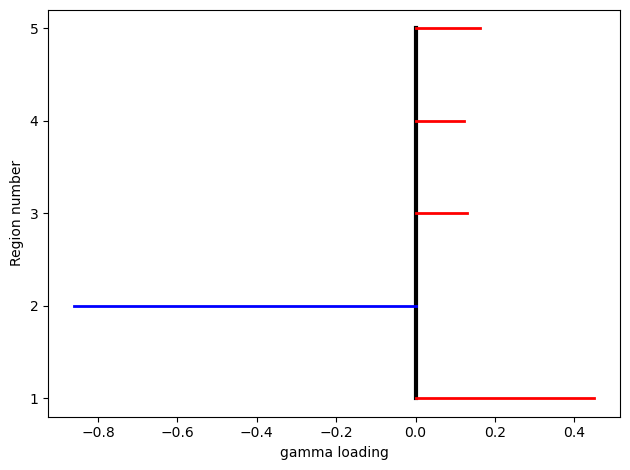

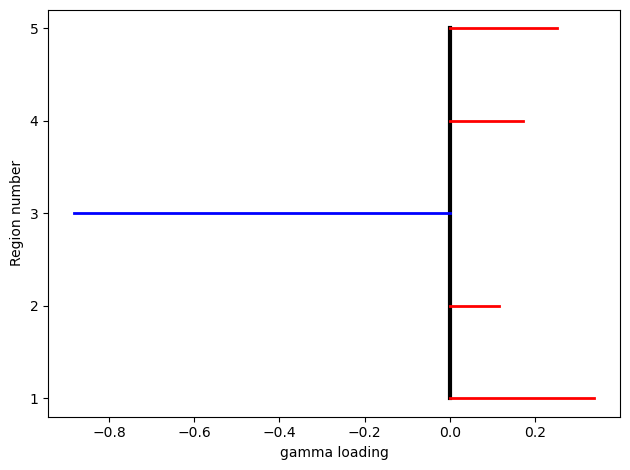

In [11]:
graphics.visualize_gamma_coefs(funcoin_new, n_comps = 2)

Each gamma projection identified projects the covariance/correlation matrix into a 1-dimensional space (similar to PCA components). We can apply this transformation to the training data or to out-of-sample data with equal dimensions. 
The transformation applied is:
$$
    u_{j,i} = \log(\gamma_j \Sigma_i \gamma_j^T)
$$
with $\gamma_j$ being projection $j$ and $\Sigma_i$ being the covariance/correlation matrix of subject $i$.

Having identified the model coefficients, we can predict the expected u value from the model by using the method predict.

In [12]:
u_training = funcoin_new.u_training #Transformed values of (u values) from the training data
u_pred = funcoin_new.predict(X_sim) #Predicted responses from the fitted model

Sometimes, we want to inspect the standard deviation of the residuals for each identified component in the model. An example is in normative modelling, where we uses the standard deviation to calculate the Z-scores. The standard devitation is stored when fitting the model and is based on all the residuals (i.e. assuming that the standard deviation does not depend on the covariates).

In [13]:
std_residuals = funcoin_new.residual_std_train
print(std_residuals)

[0.05795533 0.05588744]


To visually inspect the model fit, we now plot the transformed values (i.e. using the two identified $\gamma_j$ projections) from the training data as well as the model prediction +/- 2 standard deviations:

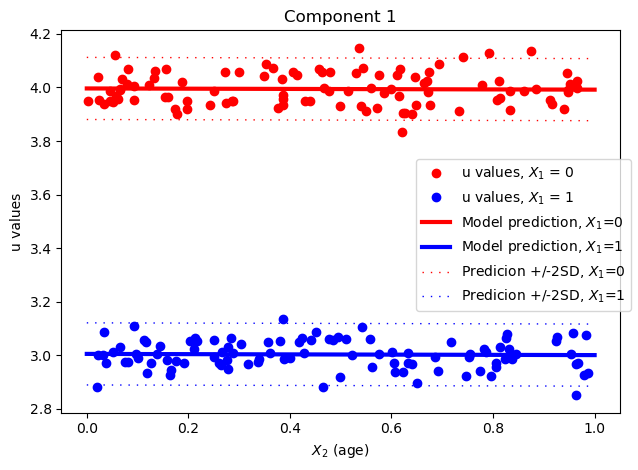

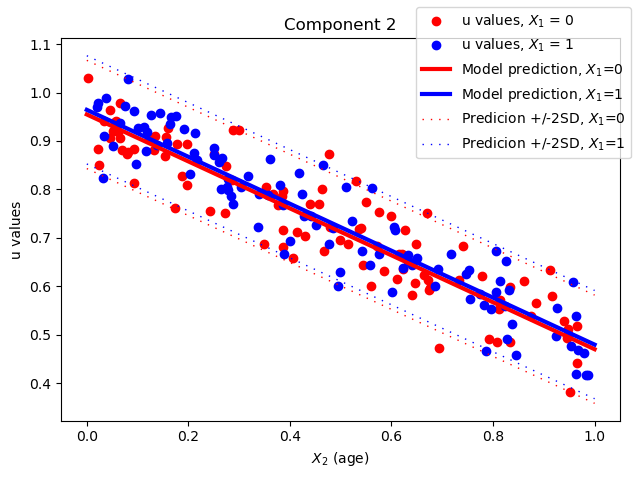

In [14]:
#Predict responses for the ends of the plotting lines
X_plot = np.array([[1,0,0], [1,0,1], [1,1,0], [1,1,1]])
y_pred_plot = funcoin_new.predict(X_plot)

for i in range(max_comps):
    minx_sex0 = np.min(X_sim[X_sim[:,1]==0,2])
    minx_sex1 = np.min(X_sim[X_sim[:,1]==1,2])
    maxx_sex0 = np.max(X_sim[X_sim[:,1]==0,2])
    maxx_sex1 = np.min(X_sim[X_sim[:,1]==1,2])

    fig, ax = plt.subplots(1)


    ax.plot(X_sim[X_sim[:,1]==0,2], u_training[X_sim[:,1]==0,i], 'ro', label='u values, $X_1$ = 0')
    ax.plot(X_sim[X_sim[:,1]==1,2], u_training[X_sim[:,1]==1,i], 'bo', label='u values, $X_1$ = 1')
    ax.plot([0,1], y_pred_plot[:2,i], 'r-', label='Model prediction, $X_1$=0', linewidth=3)
    ax.plot([0,1], y_pred_plot[2:,i], 'b-', label='Model prediction, $X_1$=1', linewidth=3)
    ax.plot([0,1], y_pred_plot[:2,i]-2*std_residuals[i], 'r', linestyle=(0,(1,5)), label='Predicion +/-2SD, $X_1$=0', linewidth=1)
    ax.plot([0,1], y_pred_plot[2:,i]-2*std_residuals[i], 'b', linestyle=(0,(1,5)), label='Predicion +/-2SD, $X_1$=1', linewidth=1)
    ax.plot([0,1], y_pred_plot[:2,i]+2*std_residuals[i], 'r', linestyle=(0,(1,5)), linewidth=1)
    ax.plot([0,1], y_pred_plot[2:,i]+2*std_residuals[i], 'b', linestyle=(0,(1,5)), linewidth=1)

    ax.set_xlabel('$X_2$ (age)')
    ax.set_ylabel('u values')
    ax.set_title(f'Component {i+1}')
    if i == 0:
        fig.legend(loc='center right')
    if i == 1:
        fig.legend(loc='upper right')

    fig.tight_layout()
    plt.show

Notice that we simulated data with one component depending on sex ($\beta_1$ = -1) and one depending on age ($\beta_2$ = -0.5). Since X<sub>1</sub> (sex) is categorical, we see the points for component 1 group in two point clouds depending on the value of X<sub>1</sub>. The second component depended on X<sub>2</sub>, we see both groups depending on age (the slope of the line).

To assess the goodness-of-fit of the log-linear model ($X$, $u_i$), we can compute a range of scores using the .score() method. This returns an array of scores, one for each identified projection. All scores in sklearn.metrics can be utilized. Any keywords applicable for the chosen score type, e.g. sample_weight, can be used. Note that keyword argument 'multioutput' will be ignored, since this function outputs scores for each projection. Like with sklearn, the score function can be applied to any both training dataset or other data.

In [15]:
#Compute insample scores:
print('Mean absolute error  for the log-linear model of the transformed covariance/correlation matrices (training data):')
MAE_insample = funcoin_new.score(X_sim, u_true=u_training, score_type='mean_squared_error')
print(MAE_insample)

print('Training data R^2 values (default score type):')
R2_insample = funcoin_new.score(X_sim, u_true=u_training, score_type='r2_score')
print(R2_insample)


Mean absolute error  for the log-linear model of the transformed covariance/correlation matrices (training data):
[0.00334203 0.00310779]
Training data R^2 values (default score type):
[0.98657097 0.86493724]


Having fitted the model on training data, we may be interested in, whether the model generalizes to out-of-sample data. In paragraph 1, we simulated time series data from from 40 subjects not used for training the model.

We can transform an out-of-sample time series dataset using the Gamma and Beta already found in the fitting procedure. Alternatively, we can transform FC matrices directly (these need to be Pearson full correlation or covariance matrices with n degrees of freedom in line with the training data).

In [16]:
#Transform time series data to u_i using the model already fitted.
u_outsample = funcoin_new.transform_timeseries(Y_out)
#Equivalently, transform the FC matrices
FC_mats = [np.cov(Y_out[i].T, ddof=0) for i in range(len(Y_out))]
u_outsample_FC = funcoin_new.transform_FC(FC_mats)

print(f'Are the two transformations equivalent?')
print(np.all(u_outsample==u_outsample_FC))


Are the two transformations equivalent?
True


To see how the model performs on test data, we evaluate the out-of-sample fit by computing best fit scores like R^2 or MSE either by parsing the time series data or by parsing the transformed values. Being out-of-sample, both the scores and the transformed variables (u values) are outputted from the method and not stored in the funcoin object.

In [17]:
#Evaluate scores on the new data inputting time series data
R2_out = funcoin_new.score(X_out, Y_dat = Y_out, score_type='r2_score')
print('\nOut-of-sample R^2 from time series:')
print(R2_out)

#Alternatively, evaluate scores on the out-of-sample u values instead
R2_out = funcoin_new.score(X_out, u_true= u_outsample, score_type='r2_score')
print('\nOut-of-sample R^2 from u values:')
print(R2_out)

#Evalutate mean squared error on test data:
MSE_out = funcoin_new.score(X_out, u_true= u_outsample, score_type='mean_squared_error')
print('\nOut-of-sample MSE from u values:')
print(MSE_out)


Out-of-sample R^2 from time series:
[0.98649402 0.83115691]

Out-of-sample R^2 from u values:
[0.98649402 0.83115691]

Out-of-sample MSE from u values:
[0.00325664 0.0035868 ]


### Calculating Z-scores for normative modelling

In normative modelling, each subject's deviance from the model prediction (given the subject's covariates) is often assessed with the Z-score, i.e. the deviance measured in number of standard deviations from the model prediction. The method calc_Zscores() returns the Z-scores under the assumption that the residuals are normally distributed and homogenous, which should be checked. It is not adviced to calculate the Z-scores after fitting with _betaLinReg_ set to False, since these model predictions are potentially biased. The same assumptions on the residuals applies for using the method with _betaLinReg_ set to True (which is default). 

We plot the Z scores of the two components for the training data and the test data:

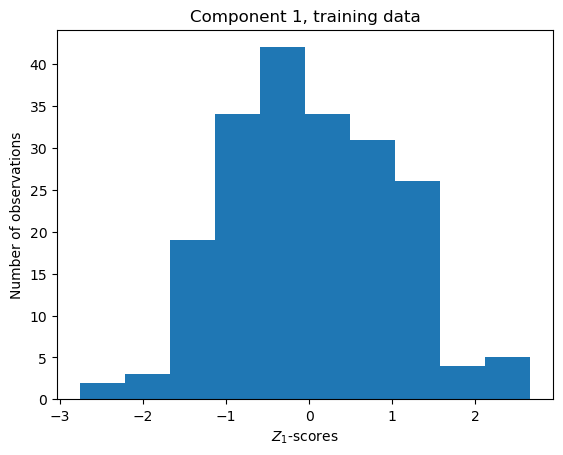

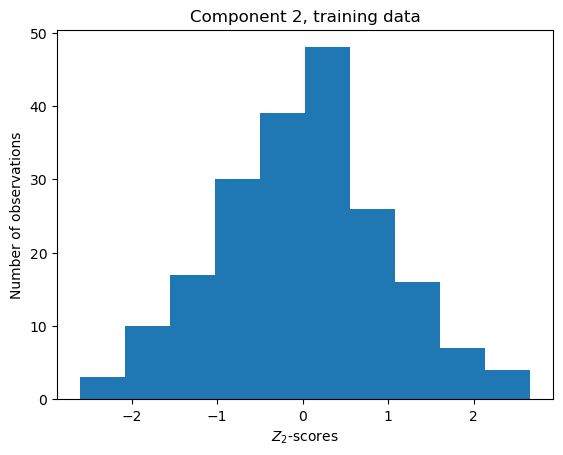

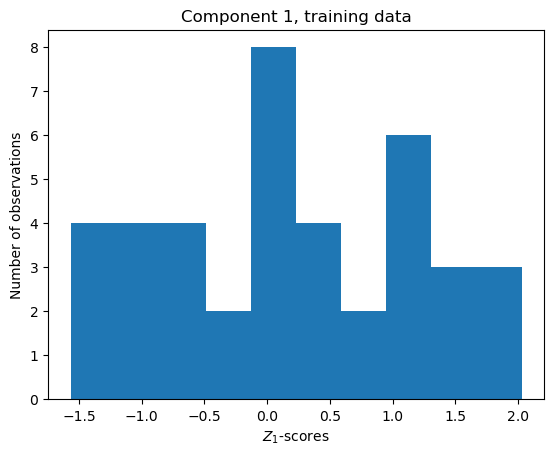

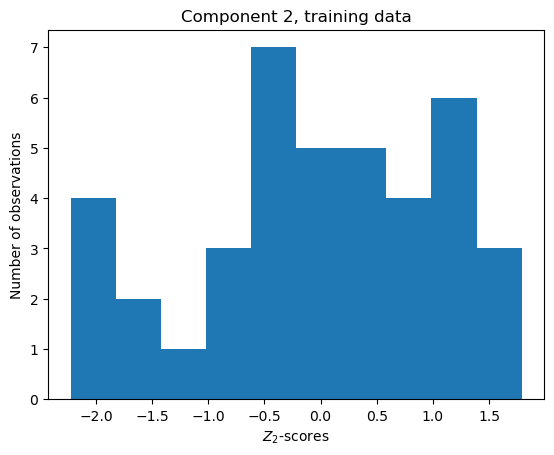

In [18]:
#Calculate out-of-sample Z-scores:
Zscores_training = funcoin_new.calc_Zscores(X_dat=X_sim, u_vals=u_training)

plt.hist(Zscores_training[:,0])
plt.xlabel('$Z_1$-scores')
plt.ylabel('Number of observations')
plt.title('Component 1, training data')
plt.show()

plt.hist(Zscores_training[:,1])
plt.xlabel('$Z_2$-scores')
plt.ylabel('Number of observations')
plt.title('Component 2, training data')
plt.show()


#Calculate out-of-sample Z-scores:
Zscores_outsample = funcoin_new.calc_Zscores(X_dat=X_out, u_vals=u_outsample)

plt.hist(Zscores_outsample[:,0])
plt.xlabel('$Z_1$-scores')
plt.ylabel('Number of observations')
plt.title('Component 1, training data')
plt.show()

plt.hist(Zscores_outsample[:,1])
plt.xlabel('$Z_2$-scores')
plt.ylabel('Number of observations')
plt.title('Component 2, training data')
plt.show()

# 4. Statistics of coefficient estimation

### Parametric confidence intervals and p-values
If fitting with betaLinReg set to true, 95% confidence intervals and p-values from t-tests are automatically calculated for each beta coefficient and stored in the funcoin object.

In [19]:
#Elementwise confidence intervals of Gamma and Beta are stored as lower and upper limit matrices
print('Fitted Beta coefficients:')
print(funcoin_new.beta)
print('\nLower border of Beta confidence interval (parametric method):')
print(funcoin_new.beta_CI95_parametric[0])
print('\nUpper border of Beta confidence interval (parametric method):')
print(funcoin_new.beta_CI95_parametric[1])
print('\np values from t-test of beta coefficients:')
print(funcoin_new.beta_pvals)
print('\nt-values of beta coefficients:')
print(funcoin_new.beta_tvals)


Fitted Beta coefficients:
[[ 3.99645407  0.95470662]
 [-0.9909787   0.00953908]
 [-0.00448015 -0.48493182]]

Lower border of Beta confidence interval (parametric method):
[[ 3.9791721   0.93804129]
 [-1.00722468 -0.00612723]
 [-0.0324091  -0.51186424]]

Upper border of Beta confidence interval (parametric method):
[[ 4.01373604  0.97137196]
 [-0.97473272  0.02520539]
 [ 0.02344879 -0.4579994 ]]

p values from t-test of beta coefficients:
[[0.         0.        ]
 [0.         0.2312776 ]
 [0.75207464 0.        ]]

t-values of beta coefficients:
[[ 4.56043186e+02  1.12974452e+02]
 [-1.20293667e+02  1.20078196e+00]
 [-3.16346261e-01 -3.55082825e+01]]


We see that the p values are very low for both intercepts, $\beta_1$ for the sex-dependent component, and $\beta_2$ for the age-dependent component. This is in line with the specifications of the simulation of the data. For the other two parameters we reject the null hypothesis on a 0.05 level.

If we want another significance level than 0.05, we can compute the confidence intervals specifying the level:

In [25]:
#Parametrically determined confidence interval
beta_CI99 = funcoin_new.CI_beta_parametric(X_dat=X_sim, CI_lvl = 0.01)
print('\nLower border of Beta 99%-confidence interval (parametric method):')
print(beta_CI99[0])
print('\nUpper border of Beta 99%-confidence interval (parametric method):')
print(beta_CI99[1])


Lower border of Beta 99%-confidence interval (parametric method):
[[ 3.97366053  0.93272637]
 [-1.01240586 -0.01112354]
 [-0.04131621 -0.52045354]]

Upper border of Beta 99%-confidence interval (parametric method):
[[ 4.01924761  0.97668688]
 [-0.96955154  0.0302017 ]
 [ 0.0323559  -0.4494101 ]]


The default t-test (shown above) tests whether the coefficients are different from 0. We can test for other coefficient values by the specifying the matrix h0_beta. Each element is the null hypothesis for the corresponding beta coefficient:

In [21]:


#t-test for each coefficient being equal to 1
h0_beta = np.ones_like(funcoin_new.beta)
beta_pvals, beta_tvals = funcoin_new.ttest_beta(X_dat=X_sim, h0_beta=h0_beta)
print('\np-values for t-test for each coefficient being equal to 1:')
print(beta_pvals)
print('\nt-values for each coefficient with the testet hypothesis (that each beta is 1):')
print(beta_tvals)


p-values for t-test for each coefficient being equal to 1:
[[0.00000000e+00 2.31680129e-07]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]

t-values for each coefficient with the testet hypothesis (that each beta is 1):
[[ 341.93123129   -5.35975576]
 [-241.68241931 -124.67947169]
 [ -70.92693305 -108.73152959]]


In the above we test whether each of the $\beta$ coefficients are different from 1. When we simulated the data, only the intercept of the age-dependent component was equal to one. In the above we must reject the null hypothesis for that coefficient (p=0.625), while the other fitted coefficients are deemed siginificantly different from 1.

### Non-parametric
To non-parametrically asses confidence intervals of the beta estimations, we can run the fitting routine with bootstrapping. This is done by calling the method .decompose_bootstrap, which takes the same arguments as the .decompose method as well as the parameters _n_sample_ and _CI_lvl_. These two parameters control the number of bootstrap samples and the significance level for the confidence intervals (default 0.05). The method first runs regular FUNCOIN decomposition on the data and sets gamma and beta. It then repeatedly samples with replacement from the data provided to generate a new dataset of the same size as the original dataset and determine the beta coefficients. The reampling and fitting is done _n_samples_ times.

When running .decompose_bootstrap(), the beta matrices from the bootstrapping procedure as well as the elementwise beta confidence intervals are stored as instance variables. The significance level used in the confidence intervals is also stored. 

Below we demonstrate the usage with only 100 bootstrap samples. This may take a little while (0.5-2 minutes).

In [22]:
funcoin_bootstrap = Funcoin()
funcoin_bootstrap.decompose_bootstrap(Y_sim, X_sim, n_samples=100, max_comps = 2, CI_lvl = 0.05, seed_bootstrap=1234) #CI_lvl is also 0.05 per default

Having run the decomposition and bootstrapping procedure, we now inspect the results:

In [23]:
#The .funcoin_bootstrap() does regular fitting of the model:
print('Is the model fitted?')
print(funcoin_bootstrap.isfitted()) 
print(' ')
#All Beta matrices from bootstrapping are stored in a list of length equal to:
print(f'Number of Beta matrices identified in bootstrapping procedure:')
print(len(funcoin_bootstrap.betas_bootstrap)) #Number of bootstrap samples (n_samples) 

#Elementwise confidence intervals of Gamma and Beta are stored as lower and upper limit matrices
print('\nConfidence level:')
print(funcoin_bootstrap.CI_lvl_bootstrap)
print('\nLower border of Beta confidence interval from bootstrapping:')
print(funcoin_bootstrap.beta_CI_bootstrap[0])
print('\nUpper border of Beta confidence interval from bootstrapping:')
print(funcoin_bootstrap.beta_CI_bootstrap[1])

Is the model fitted?
True
 
Number of Beta matrices identified in bootstrapping procedure:
100

Confidence level:
0.05

Lower border of Beta confidence interval from bootstrapping:
[[ 3.98244328  0.93888814]
 [-1.00689778 -0.00569547]
 [-0.03332957 -0.51329536]]

Upper border of Beta confidence interval from bootstrapping:
[[ 4.01381074  0.97229252]
 [-0.97478117  0.02439391]
 [ 0.02397292 -0.45465519]]


Notice that the confidence intervals from bootstrapping agree with our t-test above, where we tested if the coefficients were significantly different from 0: The bootstrap confidence intervals of the non-significant coefficients contain 0, whereas confidence intervals for the coefficients significantly different from 0 do not.

# Choosing the number of components to identify

The number of projections to indentify is a crucial parameter. In our paper, [Kobbersmed et al, 2025](https://www.biorxiv.org/content/10.1101/2025.01.13.632752v1), we determine the number of components to keep by assessing the consistency of the gamma estimations. We do this by repeatedly and randomly splitting the dataset in two and comparing the gammas identified from the two subsets of the data.

Depending on the research question and the data available, other measures may be considered e.g. the beta coefficients (if we want to keep only projections associated with certain covariates) or measures of goodness of fit e.g. explained variance.


In [Zhao et al. 2021](https://academic.oup.com/biostatistics/article/22/3/629/5680453), another data-driven approach for choosing the number of projections to keep is suggested. We compute the average "deviation from diagonality" (see [Kobbersmed et al, 2025](https://www.biorxiv.org/content/10.1101/2025.01.13.632752v1) and [Zhao et al. 2021](https://academic.oup.com/biostatistics/article/22/3/629/5680453)) for each number of projections and either threshold this value or look for a sudden large increase in average dfd value to determine a reasonable number of components to keep. Loosely speaking, the closer the average dfd value is to 1, the more "shared" the component is among the subjects.  Based on simulations, [Zhao et al.](https://academic.oup.com/biostatistics/article/22/3/629/5680453) suggests a threshold of 2.

The average dfd values of the training set are computed and stored after the fitting process and stored as an instance variable:

In [24]:
print(funcoin_new.dfd_values_training)

[1.0, 1.0034240611923726]


# References
- Kobbersmed, J.R.L., C. Gohil, A.F. Marquand, and D. Vidaurre. 2025. _One-shot normative modelling of whole-brain functional connectivity_. [https://www.biorxiv.org/content/10.1101/2025.01.13.632752v1]
- Zhao, Y., B. Wang, S. H. Mostofsky, B. S. Caffo, and X. Luo. 2021. 'Covariate Assisted Principal regression for covariance matrix outcomes', Biostatistics, 22: 629-45.